# Research Question
Does economic growth (measured by rising mean income) lead to reductions in extreme poverty, and does the level of inequality in a country affect how effectively growth reduces poverty?

## Secondary Questions that may be useful to include in poster
1. How much does poverty decrease, on average for every 1% increase in mean income?
2. Do high-inequality countries see less poverty reduction from the same amount of economic growth compared to low-inequality countries? By how much?
3. Which countries have been most successful at translating income growth into poverty reduction?

## How this Question will be answered
Using the World Bank's Poverty and Inquality Platform data, we will:

- Calculate the correlation between income growth and changes in poverty rates
- Compare poverty reduction in high-inequality vs. low-inequality countries
- Create visualizations showing the relationship between groth and poverty over time.
- Conduct hypothesis tests to determine if inequality significantly affects the growth-poverty relationship.
- Identify specific country examples of successful / unsuccessful poverty reduction (for poster)

# Dataset Description
We will be using the World Bank Poverty and Inequality Platform dataset from:  https://github.com/owid/poverty-data
This dataset covers over 150 countries, with years ranging from 1967-2021 and a large sample size. 

# Variables
## Variables from Dataset that we will be using to answer our research question
|Variable Name|Econometric Type|Description|Why We Chose This Variable|
|:-----------:|:--------------:|:---------:|:-----------------------:|
|country|Qualitative (Categorical)|Country Name (standardized|Identifier for observations; enables cross-country comparisons|
|year|Quantitative (Discrete/Time)|Year of survery observation|Essential for time series analysis and tracking changes over time|
|reporting_level|Qualitative (Categorical|National, Urban, or Rural|Filter to ensure we use only national-level data for consistency|
|mean|Quantitative (Continuous)|Mean income/expenditure per day (USD) |It is the primary measure of economic prosperity. Shows overall income level|
|median|Quantitative (Continous)| Median income/expenditure per day (USD)|It is the alternative prosperity measure; less affected by extreme values|
|headcount_ratio_international_povline|Quantitative (Continuous)|% of population below $2.15 / day (based on 2017 PPP)|It is the main dependent variable. This is the international standard for measuring extreme poverty|
|gini|Quantitative (Continuous)|Gini coefficient (0-1)|It is a key explanatory variable for inequality. It measures income inequality where 0 = perfect equality and 1 = perfect inequality|
|decile1_avg|Quantitative (Continuous)|Mean income of the poorest 10% of the population|Shows whether the poorest segment benefits from overall income growth|
|decile10_avg|Quantitative (Continuous)|Mean income of the richest 10% of the population|Shows income levels at the top of the distribution|
|palma_ratio|Quantitative (Continuous)|Ratio of income share of top 10% to bottom 40%|Alternative inequality measure that focuses on the extremes of the income distribution|


## Derived Variables we will create during anaylsis
|Variable Name|Econometric Type|How it will be created|Why We Need This Variable|
|:-----------:|:--------------:|:---------:|:-----------------------:|
|mean_growth|Quantitative (Continuous)|(mean[t] - mean[t-1]) / mean[t-1] × 100|Calculates the percentage change in mean income from one year to the next. This is our measure of economic growth|
|poverty_change|Quantitative (Continuous)|headcount_ratio[t] - headcount_ratio[t-1]|Calculates the percentage point change in poverty rate. Negative values indicate poverty reduction|
|high_inequality|Qualitative (Binary/Dummy)|1 if gini > median(gini), 0 otherwise|Creates two groups (high vs low inequality) for comparison. Allows us to test if the growth-poverty relationship differs by inequality level|
|decade|Qualitative (Categorical)|Groups years into 1990s, 2000s, 2010s, 2020s|Allows us to examine whether the relationship between growth and poverty has changed over time|

# Basic Statistics
|    N (observations)|Variable                              |    Mean|    SD|     Min|     Max|
|----:|:-------------------------------------|-------:|-----:|-------:|-------:|
| 4049|year                                  | 2006.14|  9.26| 1967.00| 2021.00|
| 4049|mean                                  |   21.31| 18.63|    0.74|   85.87|
| 4049|median                                |   17.29| 16.12|    0.53|   69.48|
| 4049|headcount_ratio_international_povline |    9.47| 17.25|    0.00|   94.28|
| 4049|gini                                  |    0.38|  0.09|    0.20|    0.66|
| 4049|decile1_avg                           |    6.00|  6.21|    0.02|   26.91|
| 4049|decile10_avg                          |   57.79| 45.78|    2.41|  264.25|
| 4049|palma_ratio                           |    1.89|  1.15|    0.68|    8.34|


# Group Charter
## Roles:
- Sophie Ang: Lead/Project Manager
- Lianne Chen: Data Wrangler
- Minh Anh: Analyst
- Erics Wu: Writer & QA
## Planning:
We’ve created a group chat to help everyone stay in touch and share updates quickly. We’ll have
a regular weekly meeting to check how things are going, discuss what to do next, and solve any
problems. Each person is responsible for their own tasks, and we’ll keep track of what everyone
is working on to make sure things are fair. If any issues come up, we’ll talk about them right
away, change plans if needed, and help each other to keep the project moving smoothly.
## Group Expectations:
1. Submit assigned work by internal deadlines.
2. Keep R code reproducible and properly commented.
3. Respect each other’s opinions and workloads.
4. Communicate early if problems occur.
5. Academic integrity is mandatory; all analyses must be original.






In [1]:
library(tidyverse)
library(dplyr)
library(broom)

pip <- read_csv("pip_dataset.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 4877 Columns: 108
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (3): country, reporting_level, welfare_type
dbl (105): year, ppp_version, survey_year, survey_comparability, headcount_r...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [2]:
# select variables
df <- pip |>
  select(country, year, mean, 
         headcount_ratio_international_povline,
         gini) |>
  drop_na() |>
  arrange(country, year)

# see year to year changes 
df <- df |>
  group_by(country) |>
  mutate(d_mean = mean - lag(mean),
         d_poverty = headcount_ratio_international_povline - lag(headcount_ratio_international_povline)) |>
  ungroup() |>
  drop_na(d_mean, d_poverty)


<p>Because our research question focuses on how changes in income translate to changes in poverty, transform the original dataset to calculate year-to-year changes within each country. There are two key variables: the change in mean income and the change in the headcount poverty rate using the international $2.15/day line. By doing this, we can directly examine whether countries that experience growth also see immediate reductions in poverty. Sorting the data by country and year ensures that the changes that are calculated reflect real progression over time rather than jumping between mismatched observations.</p>

In [3]:
# Correlation Analysis
cor_overall <- cor.test(df$d_mean, df$d_poverty)

median_gini <- median(df$gini)

low_ineq  <- df |> filter(gini <= median_gini)
high_ineq <- df |> filter(gini > median_gini)

cor_low  <- cor.test(low_ineq$d_mean, low_ineq$d_poverty)
cor_high <- cor.test(high_ineq$d_mean, high_ineq$d_poverty)

cor_overall
cor_low
cor_high



	Pearson's product-moment correlation

data:  df$d_mean and df$d_poverty
t = -9.0307, df = 4230, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1669697 -0.1078487
sample estimates:
       cor 
-0.1375317 



	Pearson's product-moment correlation

data:  low_ineq$d_mean and low_ineq$d_poverty
t = -3.7792, df = 2114, p-value = 0.0001617
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.12409861 -0.03944485
sample estimates:
        cor 
-0.08191948 



	Pearson's product-moment correlation

data:  high_ineq$d_mean and high_ineq$d_poverty
t = -10.717, df = 2114, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2670349 -0.1861944
sample estimates:
       cor 
-0.2270056 


<p>We first examine whether growth and poverty reduction are related to each other in a meaningful way. Across the full dataset, there is a negative correlation, meaning that increases in income are associated with reductions in poverty. However, the relationship is weak, indicating that growth does not always translate into improvements for the poor. When we split the sample based on inequality levels, the association becomes stronger in high-inequality countries but remains weak in low-inequality countries. This suggests that countries facing more extreme poverty may exhibit larger changes in poverty statistics when growth occurs, even though those gains may not be evenly distributed.</p>

# Regression



In [4]:
model <- lm(d_poverty ~ d_mean + gini, data = df)
summary(model)


Call:
lm(formula = d_poverty ~ d_mean + gini, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-49.912  -0.871   0.591   1.572  43.606 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.45762    0.42712  -1.071    0.284    
d_mean      -0.27009    0.02993  -9.025   <2e-16 ***
gini         0.24013    1.10867   0.217    0.829    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.356 on 4229 degrees of freedom
Multiple R-squared:  0.01893,	Adjusted R-squared:  0.01846 
F-statistic: 40.79 on 2 and 4229 DF,  p-value: < 2.2e-16


<p>To test whether inequality affects how effectively growth reduces poverty, we can run a regression using both income change and inequality as predictors of poverty change. Income growth remains a statistically significant predictor of falling poverty rates after controlling for inequality differences across countries. The coefficient on inequality, however, is not statistically significant. This shows that inequality does not appear to alter the extent to which growth reduces poverty in this model. As a result, we can conclude that while inequality can still matter for many social outcomes, its role in moderating the growth–poverty relationship is limited in this dataset.</p>

<h1>Visualizing Results</h1>

<h2>Economic Growth vs. Poverty Reduction</h2>

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


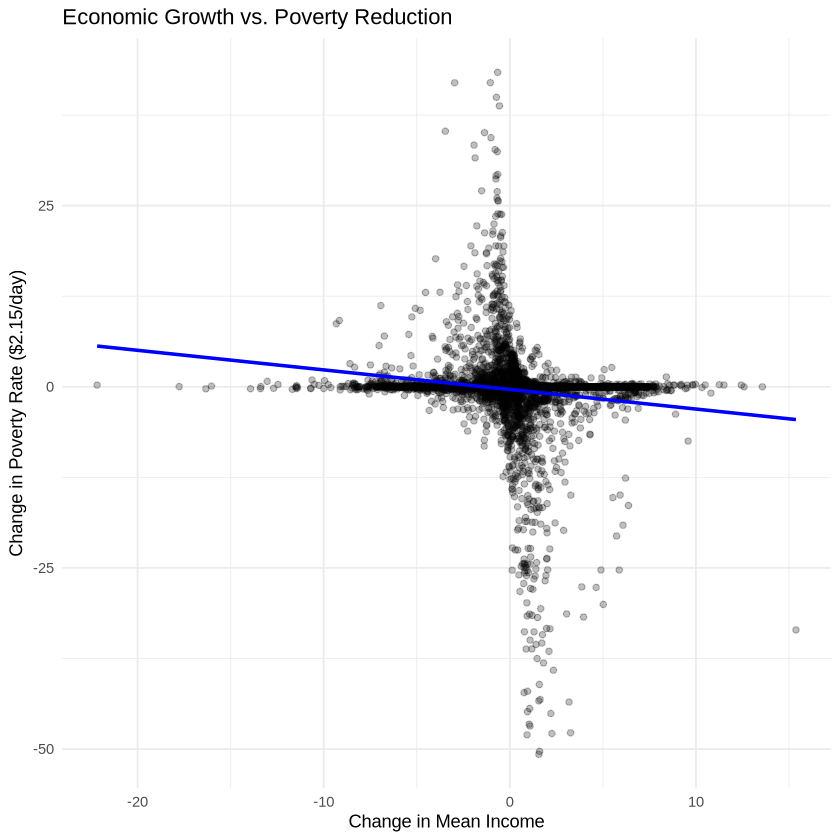

In [5]:
plot1 <- ggplot(df, aes(x = d_mean, y = d_poverty)) +
  geom_point(alpha = 0.25) +
  geom_smooth(method = "lm", se = FALSE, color = "blue", size = 1) +
  labs(title = "Economic Growth vs. Poverty Reduction",
       x = "Change in Mean Income",
       y = "Change in Poverty Rate ($2.15/day)") +
  theme_minimal()
plot1

<p>This figure supports our preliminary findings that countries who experience income growth generally see declining poverty rates, as indicated by the downward-sloping trend line. However, the considerable spread of data points shows that income growth alone does not guarantee effective poverty reduction — many other factors contribute to differences in country outcomes.</p>

<h2>Comparing High vs Low Inequality Countries</h2>

`geom_smooth()` using formula = 'y ~ x'


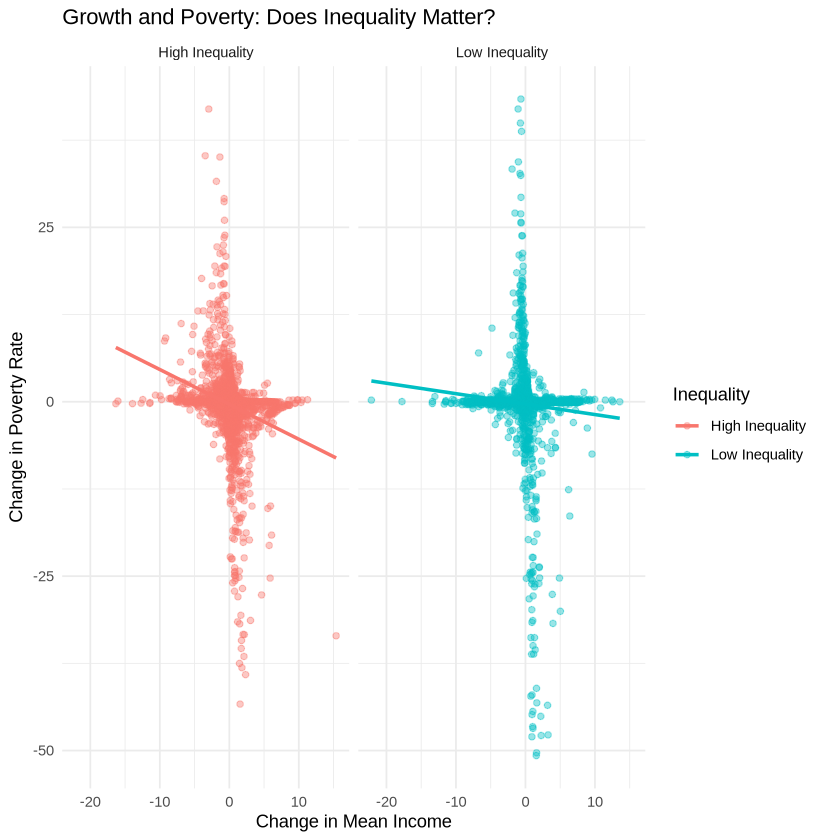

In [6]:
high_vs_low_plot <- df |>
  mutate(Inequality = ifelse(gini > median_gini, "High Inequality", "Low Inequality")) |>
  ggplot(aes(d_mean, d_poverty, color = Inequality)) +
  geom_point(alpha = 0.4) +
  geom_smooth(method = "lm", se = FALSE) +
  facet_wrap(~ Inequality) +
  labs(title = "Growth and Poverty: Does Inequality Matter?",
       x = "Change in Mean Income",
       y = "Change in Poverty Rate") +
  theme_minimal()
high_vs_low_plot 

When we separate countries by inequality level, the growth–poverty link appears more pronounced in high-inequality countries, with a steeper negative trend line. However, the data also show wider volatility, illustrating that these countries may be more vulnerable to policy failures and economic crises. Low-inequality countries tend to show steadier but less dramatic improvements.

<h2>Changes in Poverty Over Time</h2>

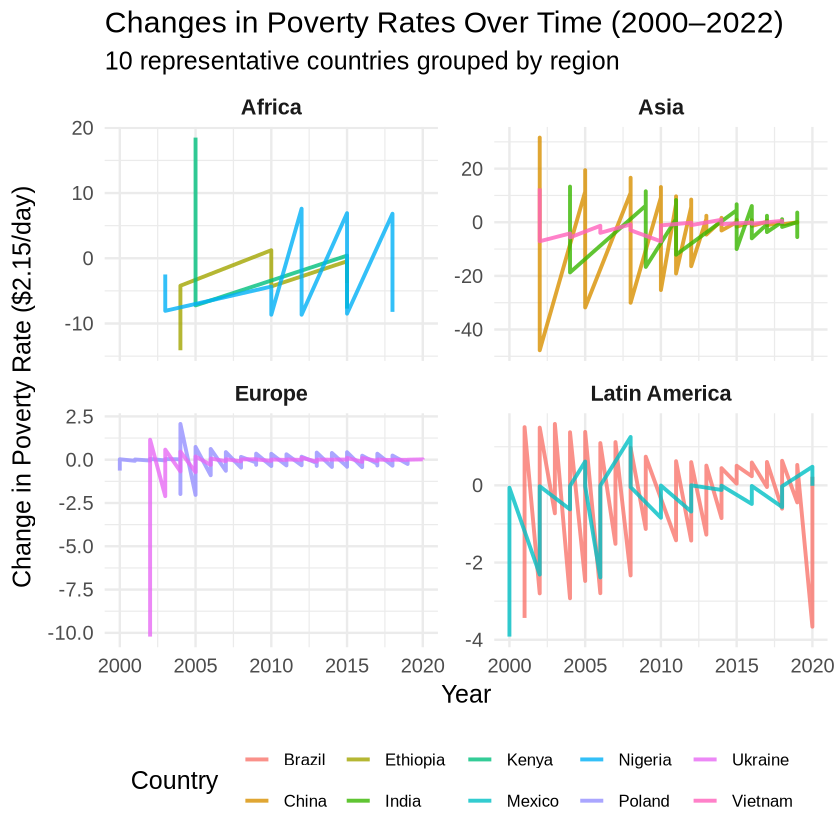

In [13]:
# region selection mapping
region_map_small <- tribble(
  ~country,       ~region,
  "Nigeria",      "Africa",
  "Kenya",        "Africa",
  "Ethiopia",     "Africa",
  "India",        "Asia",
  "China",        "Asia",
  "Vietnam",      "Asia",
  "Brazil",       "Latin America",
  "Mexico",       "Latin America",
  "Poland",       "Europe",
  "Ukraine",      "Europe"
)

# merge & filter dataset
df_small <- df |>
  inner_join(region_map_small, by = "country") |>
  filter(year >= 2000) |>    
  group_by(country) |>
  filter(n() >= 3) |>       
  ungroup()


# plot
over_time_plot <- ggplot(df_small, aes(x = year, y = d_poverty, color = country)) +
  geom_line(linewidth = 1.1, alpha = 0.8) +
  facet_wrap(~ region, scales = "free_y") +
  labs(
    title = "Changes in Poverty Rates Over Time (2000–2022)",
    subtitle = "10 representative countries grouped by region",
    x = "Year",
    y = "Change in Poverty Rate ($2.15/day)",
    color = "Country"
  ) +
  theme_minimal(base_size = 15) +
  theme(
    legend.position = "bottom",
    legend.text = element_text(size = 10),
    strip.text = element_text(face = "bold", size = 13)
  )

over_time_plot

This figure focuses on ten well-known countries that represent different regional development trends and poverty experiences. We restrict the visualization to 2000–2022 so that the results reflect the modern global economy. Africa (Nigeria, Kenya, Ethiopia) shows larger fluctuations in poverty reduction, reflecting exposure to economic shocks and weaker safety nets. Asia (China, India, Vietnam) shows more consistent and rapid improvements, highlighting how growth-driven industrialization translates into poverty reduction. Latin America (Brazil, Mexico) demonstrates slower and less stable progress due to inequality and frequent economic downturns. Europe (Poland, Ukraine) has relatively small year-to-year changes because poverty is already low, with recent volatility in Ukraine due to conflict.

<h1>Final Explanation</h1>
<p>Our results indicate that economic growth generally contributes to poverty reduction. The regression analysis shows a statistically significant relationship between increases in mean income and decreases in the international poverty headcount rate. This supports the idea that growth plays an important role in improving living standards for low-income populations.

However, the strength of this relationship is modest and differs widely across countries. Many nations experience years where growth does not translate into meaningful poverty reduction, reflecting differences in social policies, economic structure, and vulnerability to external shocks. Inequality also does not significantly alter how much growth reduces poverty in our model, suggesting that context and governance may matter more than inequality levels alone. The regional comparison emphasizes these differences, as Asian countries tend to see more steady progress, while African and Latin American countries experience larger setbacks or slower improvements.

Overall, the findings show that while growth is necessary for reducing poverty, it is not sufficient on its own. Countries need effective policies to ensure that rising incomes reach the most vulnerable groups.</p>

<h1>Limitations</h1>
This analysis relies on cross-country data that varies in measurement quality and survey frequency, which may introduce noise into year-to-year changes. The model also does not account for other key determinants of poverty reduction, such as social protection spending, education access, political stability, or sectoral growth differences. Additionally, the use of a single global poverty line and differences in national survey methodologies may limit comparability across regions. These factors suggest that future work could incorporate more country-specific variables to better explain why some nations translate growth into poverty reduction more effectively than others.

<h1>References</h1>
Dataset - https://github.com/owid/poverty-data/tree/main/datasets